# TEST DRIVE

* [Cointegration-v1](#Cointegration-v1)
* [Cointegration-v2](#Cointegration-v2)

# Cointegration v1

Testing some concepts with some pre-coded functions on VAR and Time Series

In [15]:
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np

# Reuters API
import eikon as ek
ek.set_app_id('D79B714919385CD9D749D1')

# Statistical models
import statsmodels
from statsmodels.tsa.stattools import coint

# Plotting
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (18, 8)})  # set figure size

## Data

Get basket of commodities CLOSE price data since 2009 to 31-May-2016. Motivation for this basket:
* correlation between Crude, Coal, Gas, Power and Carbon
* including most liquid contracts only to allow more position taking in trading strategies

In [40]:
comm_list = [
    # Crude
    "LCOc1",  # Brent
    "LGOc1",  # Brent heating oil
    "CLc1",  # WTI
    "HOc1",  # WTI heating oil
    "CFI2Zc1",  # Carbon
    "TRAPI2Mc1",  # Coal
    "TRGBNBPMc1",  # NBP Gas
    "TRNLTTFMc1",  # TTF Gas
    "TRDEBMc1",  # Power - Germany
    "TRFRBMc1",  # Power - France
    "TRESBMc1",  # Power - Spain
    "TRGBBMc1"  # Power - UK
]

## Define data range
# today = datetime.today()
# one_day = timedelta(days=1)
# yesterday = today - one_day
start_date = datetime(2009, 1, 1)
end_date = datetime(2016, 5, 31)

list_dfs = []
for k in comm_list:
    dic = ek.get_timeseries([k], start_date=start_date, end_date=end_date, interval='daily', fields=['CLOSE'])
    print "Finished ", k
    df = dic[k]  # put from dic into df
    df.columns = [k]  # rename columns to RICs code
    list_dfs += [df]

# Outer join
oj = pd.concat(list_dfs, axis=1, join='outer')


Finished  LCOc1
Finished  LGOc1
Finished  CLc1
Finished  HOc1
Finished  CFI2Zc1
Finished  TRAPI2Mc1
Finished  TRGBNBPMc1
Finished  TRNLTTFMc1
Finished  TRDEBMc1
Finished  TRFRBMc1
Finished  TRESBMc1
Finished  TRGBBMc1


In [41]:
oj.head()

,LCOc1,LGOc1,CLc1,HOc1,CFI2Zc1,TRAPI2Mc1,TRGBNBPMc1,TRNLTTFMc1,TRDEBMc1,TRFRBMc1,TRESBMc1,TRGBBMc1
2009-01-01,NaN,NaN,NaN,NaN,NaN,82.00,60.55,21.45,62.00,66.00,52.5,60.50
2009-01-02,46.91,427.75,46.34,1.4803,15.55,80.75,60.55,20.15,62.00,68.75,53.0,60.50
2009-01-05,49.62,478.75,48.81,1.5763,15.38,85.00,57.00,20.75,58.40,67.50,52.5,59.75
2009-01-06,50.53,514.50,48.58,1.6263,15.69,89.00,60.75,23.06,60.05,69.50,52.5,62.00
2009-01-07,45.86,500.50,42.63,1.5431,15.45,86.50,60.75,22.19,60.05,68.00,53.4,62.00


### Clean-up

In [42]:
# Do some data prep on missing values
df = oj.copy()

## NaN indicator column
# for k in df:
#     s = 'NaN.' + k
#     df[s] = df[k].isnull()

# forward fill NaN's with previous value
df = df.fillna(method='pad')

# fill with zeroes what doesn't have a past value
df = df.fillna(0)

In [43]:
df.head()

,LCOc1,LGOc1,CLc1,HOc1,CFI2Zc1,TRAPI2Mc1,TRGBNBPMc1,TRNLTTFMc1,TRDEBMc1,TRFRBMc1,TRESBMc1,TRGBBMc1
2009-01-01,0.00,0.00,0.00,0.0000,0.00,82.00,60.55,21.45,62.00,66.00,52.5,60.50
2009-01-02,46.91,427.75,46.34,1.4803,15.55,80.75,60.55,20.15,62.00,68.75,53.0,60.50
2009-01-05,49.62,478.75,48.81,1.5763,15.38,85.00,57.00,20.75,58.40,67.50,52.5,59.75
2009-01-06,50.53,514.50,48.58,1.6263,15.69,89.00,60.75,23.06,60.05,69.50,52.5,62.00
2009-01-07,45.86,500.50,42.63,1.5431,15.45,86.50,60.75,22.19,60.05,68.00,53.4,62.00


In [44]:
df.shape

(1929, 12)

## Finding cointegrated pair

Look in commodities basket to see if any of them are cointegrated. Idea taken from this [Quantopian notebook](https://www.quantopian.com/research/notebooks/Cloned%20from%20%22Updated%20Pairs%20Trading%20Lecture%3A%20Now%20With%20Less%20Wind%20Resistance%22.ipynb)

In [5]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:  # 5% C.L. to reject null hypothesis
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


### Energy Futures

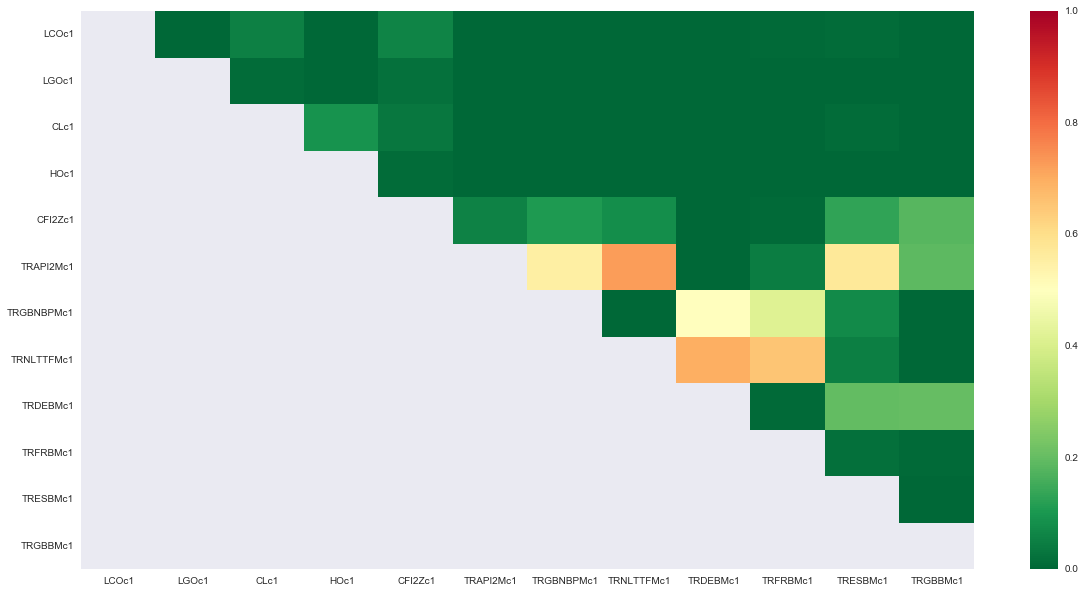

In [70]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap

scores, pvalues, pairs = find_cointegrated_pairs(df)
_ = sns.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r', mask = (pvalues >= 0.95),
            #vmin=0.0, vmax=0.1
           )

#### Brent crude vs Heating Oil

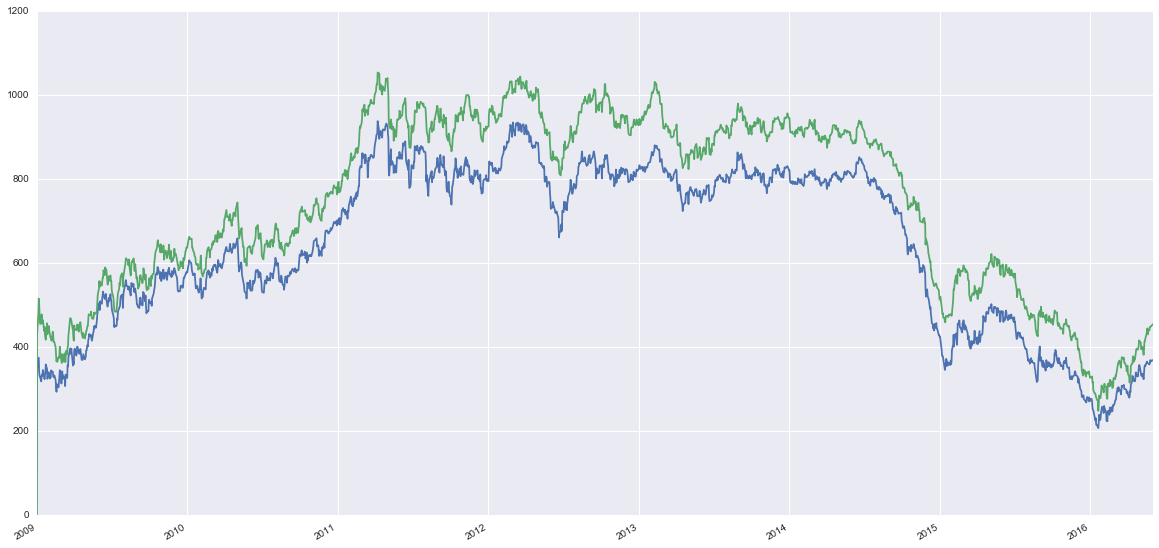

In [50]:
(df.LCOc1*7.4).plot()
df.LGOc1.plot()

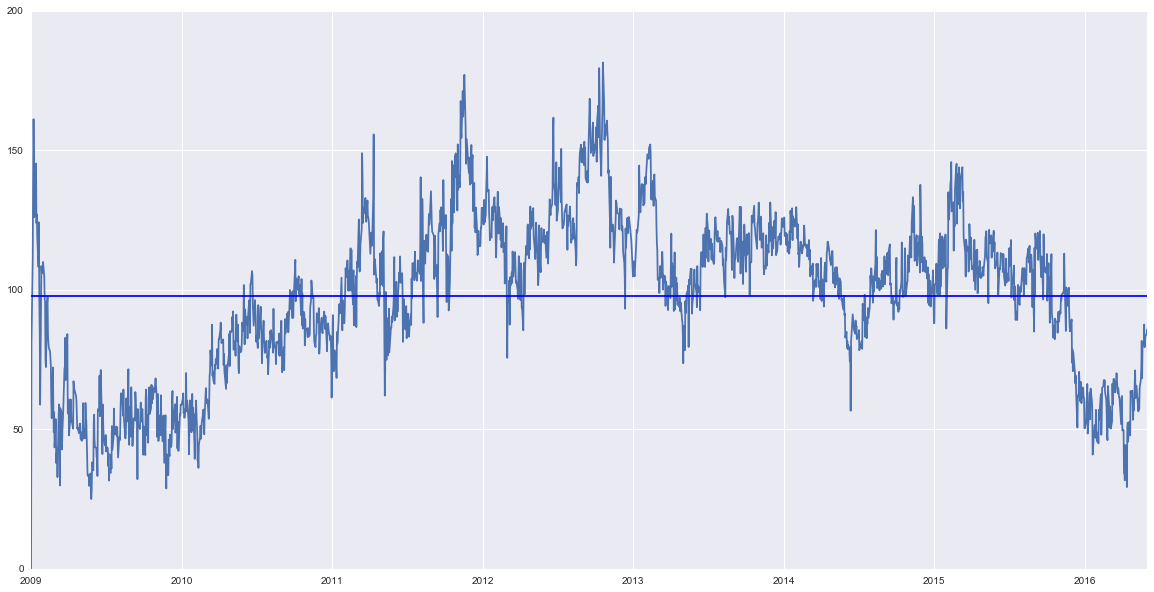

In [58]:
import matplotlib.pyplot as plt
r = df.LGOc1-7.4*df.LCOc1
plt.plot(r)
plt.axhline(r.mean())


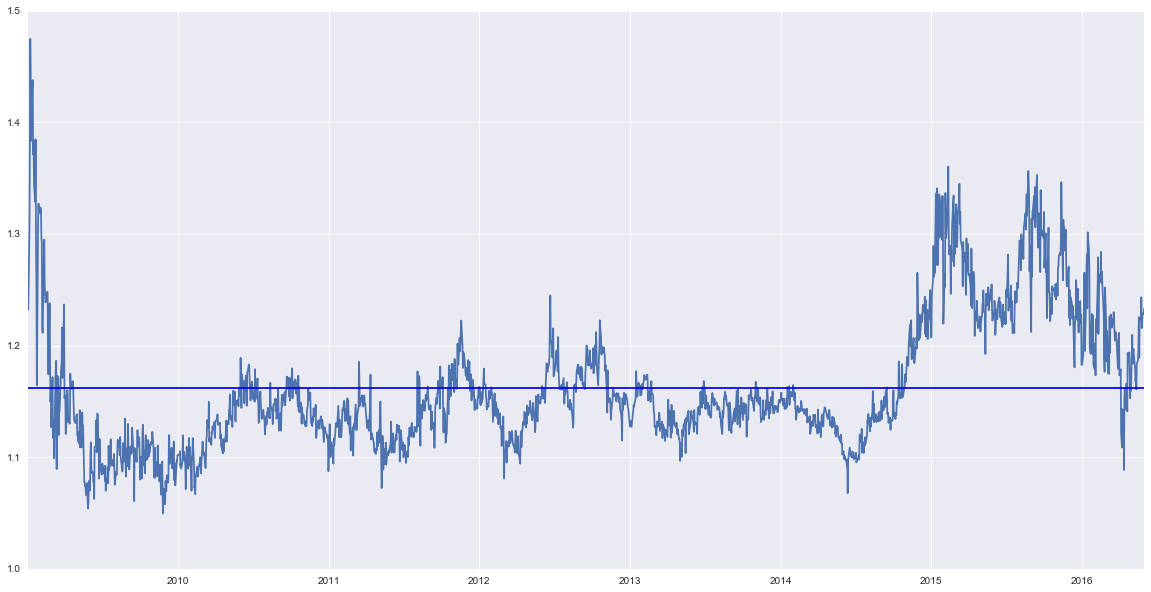

In [57]:
r2 = df.LGOc1/(7.4*df.LCOc1)
plt.plot(r2)
plt.axhline(r2.mean())

#### Italy Gas & TTF

Season ahead prices for PSV (Italy gas) and TTF. Source: Otis (Shell internal database)

In [21]:
df_gas = pd.read_excel("data/PSV_TTF.xlsx", sheetname="Sheet1", index_col=0, dayfirst=True)

In [22]:
df_gas.head()

,HERENPSVSEA01SPOTM,HERENTTFSEA01SPOTM
2010-06-03,26.70,20.25
2010-06-04,26.50,21.60
2010-06-07,27.00,22.15
2010-06-08,28.75,22.50
2010-06-09,29.00,22.55


In [27]:
df_gas.tail()

,HERENPSVSEA01SPOTM,HERENTTFSEA01SPOTM
2016-05-24,16.7625,14.7625
2016-05-25,16.9625,15.0375
2016-05-26,17.0500,15.2750
2016-05-27,17.2750,15.4750
2016-05-31,17.6000,15.8000


array([[ 1.        ,  0.00622981],
       [ 1.        ,  1.        ]])

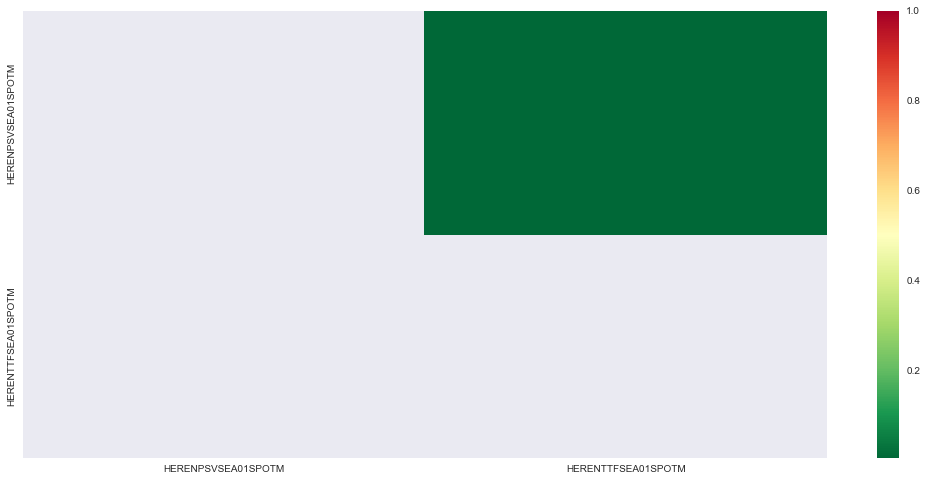

In [26]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap

scores, pvalues, pairs = find_cointegrated_pairs(df_gas)
_ = sns.heatmap(pvalues, xticklabels=df_gas.columns, yticklabels=df_gas.columns, cmap='RdYlGn_r', mask = (pvalues >= 0.95),
            #vmin=0.0, vmax=0.1
           )

pvalues

### Corn, Soya & Wheat Futures

In [18]:
import parse_data
reload(parse_data)

start_date = datetime(2009, 1, 1)
end_date = datetime(2016, 5, 31)
df_csw = parse_data.parse_data(start_date, end_date, ["Cc1", "Sc1", "Wc1", "LCOc1"])

Finished  Cc1
Finished  Sc1
Finished  Wc1
Finished  LCOc1


In [19]:
df2.head()

,Cc1,Sc1,Wc1,LCOc1
2009-01-02,412.25,970.00,611.00,46.91
2009-01-05,411.25,983.75,616.75,49.62
2009-01-06,427.50,1014.25,643.50,50.53
2009-01-07,416.50,990.00,613.25,45.86
2009-01-08,406.75,989.00,612.50,44.67


array([[ 1.        ,  0.21070622,  0.0354656 ,  0.33401698],
       [ 1.        ,  1.        ,  0.00487297,  0.06822234],
       [ 1.        ,  1.        ,  1.        ,  0.04118663],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

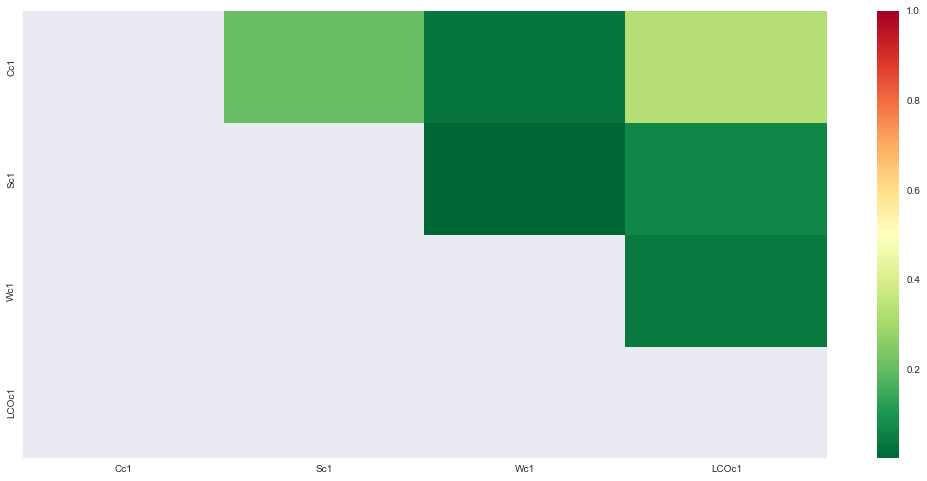

In [25]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap

scores, pvalues, pairs = find_cointegrated_pairs(df_csw)
_ = sns.heatmap(pvalues, xticklabels=df_csw.columns, yticklabels=df_csw.columns, cmap='RdYlGn_r', mask = (pvalues >= 0.95),
            #vmin=0.0, vmax=0.1
           )
pvalues

# Cointegration v2

In this section we study the cointegration between Italy gas and TTF gas. The motivation for this is that these are connected through pipelines which are sometimes completely full (then prices can diverge) and sometimes not (then prices converge).


In [28]:
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (18, 8)})  # set figure size

# Stats models
import statsmodels.tsa.stattools as ts  # for ADF test
import statsmodels.api as sm  # for OLS

In [4]:
df_gas = pd.read_excel("data/PSV_TTF.xlsx", sheetname="Sheet1", index_col=0, dayfirst=True)
df_gas.columns = ["PSV", "TTF"]
df_gas.head()

,PSV,TTF
2010-06-03,26.70,20.25
2010-06-04,26.50,21.60
2010-06-07,27.00,22.15
2010-06-08,28.75,22.50
2010-06-09,29.00,22.55


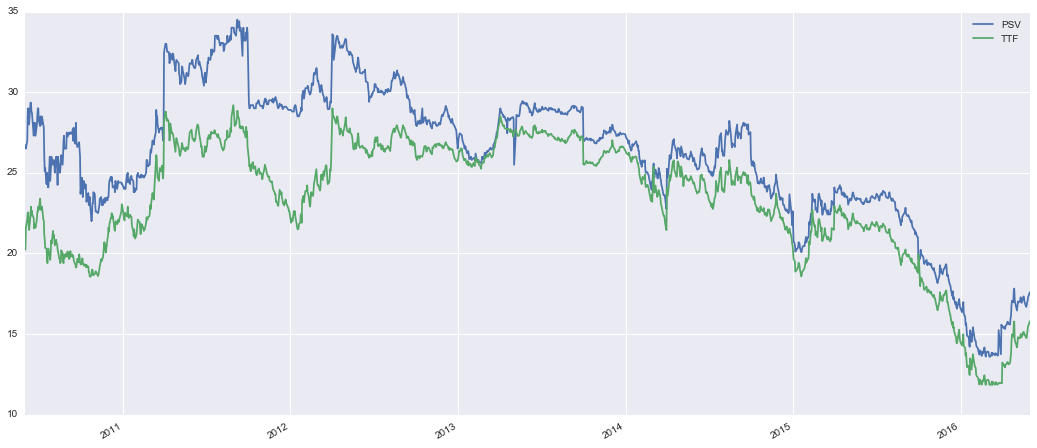

In [29]:
df_gas.plot()

If we create a scatter plot of their prices, we see that the relationship is broadly linear (see Figure 2) for this period.

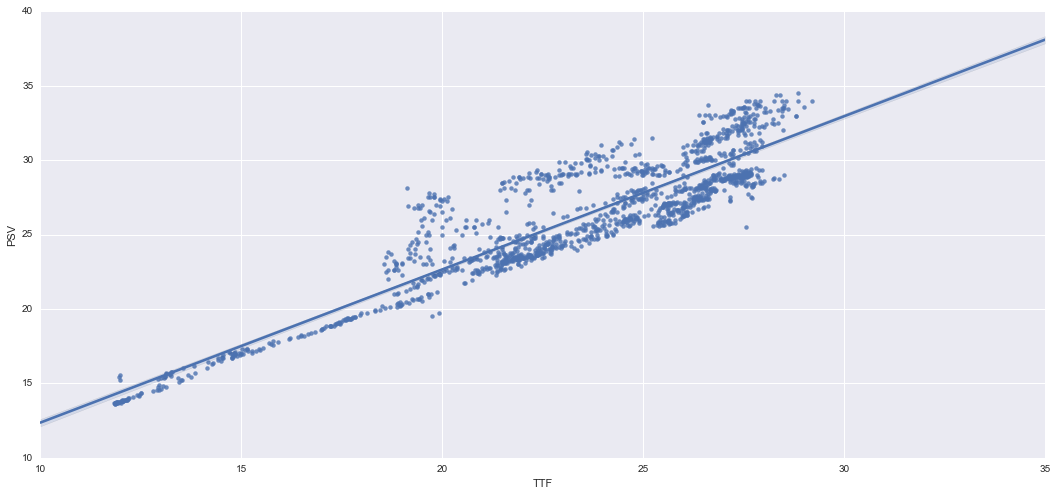

In [17]:
_ = sns.regplot(x=df_gas.TTF, y=df_gas.PSV)

## ADF test (on individual TS)

This test is based on the fact that if prices are mean reverting, then the next price level will be proportional to the current level. It then tests for the presence of a **unit root** in the **autoregressive** series. If the ADF statistic is then used to reject the _null hypothesis_ (the series is not mean-reverting) if it's below a prescribed threshold.

In [10]:
print ts.adfuller(df_gas.PSV, maxlag=1)
print ts.adfuller(df_gas.TTF, maxlag=1)

(-1.0783791102673104, 0.7236166091375883, 1L, 1512L, {'5%': -2.8634534376843637, '1%': -3.43468229933681, '10%': -2.5677886890239634}, 1642.2844150315559)
(-1.1087925999519574, 0.71155281076053467, 0L, 1513L, {'5%': -2.8634521717811046, '1%': -3.4346794310731665, '10%': -2.5677880149215722}, 866.379566582606)


The first value is the calculated test-statistic, while the second value is the p-value. The fourth is the number of data points in the sample. The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively.

Since the calculated value of the test statistic is larger than any of the critical values at the 1, 5 or 10 percent levels, we cannot reject the null hypothesis of $\gamma = 0$ and thus we are unlikely to have found a mean reverting time series.

## Pairs Trading and Cointegration

The pairs trade essentially works by using a linear model for a relationship between the two stock prices:
$$y(t)=\beta x(t)+ \epsilon(t)$$
Where $y(t)$ is the price of stock 'A' and $x(t)$ is the price of stock 'B', both on day $t$.

If we plot the residuals $\epsilon(t)=y(t)−\beta x(t)$ (for a particular value of $\beta$ that we will determine below) we create a new time series that, at first glance, looks relatively stationary. 

In order to statistically confirm whether this series is mean-reverting we could use a statistical test, like ADF or Hurst Exponent. However, neither of these tests will actually help us determine $\beta$, the hedging ratio needed to form the linear combination, they will only tell us whether, for a particular $\beta$, the linear combination is stationary.

### Finding the hedging ratio $\beta$

The optimal $\beta$ can be found using a linear regression against the two time series. Once obtained, we then test for stationarity using ADF or similar.

In [31]:
# Less pretty way to set OLS

import statsmodels.api as sm

X = df_gas.TTF
X = sm.add_constant(X)
y = df_gas.PSV

mod = sm.OLS(y, X)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                    PSV   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     7823.
Date:                Fri, 03 Jun 2016   Prob (F-statistic):               0.00
Time:                        11:29:12   Log-Likelihood:                -3047.0
No. Observations:                1514   AIC:                             6098.
Df Residuals:                    1512   BIC:                             6109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.0763      0.275      7.552      0.0

In [32]:
# Quantopian version
import statsmodels.api as sm

# Let's define everything in familiar regression terms
X = df_gas.TTF.values # Get just the values, ignore the timestamps
Y = df_gas.PSV.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    # model = regression.linear_model.OLS(y,x).fit()
    model = sm.OLS(y, x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: 2.07627327287
beta: 1.02911938046



If we plot the line $\beta x(t)+ \epsilon(t)$, we can see that it does indeed look like the line of best fit, as in the sns scatter plot

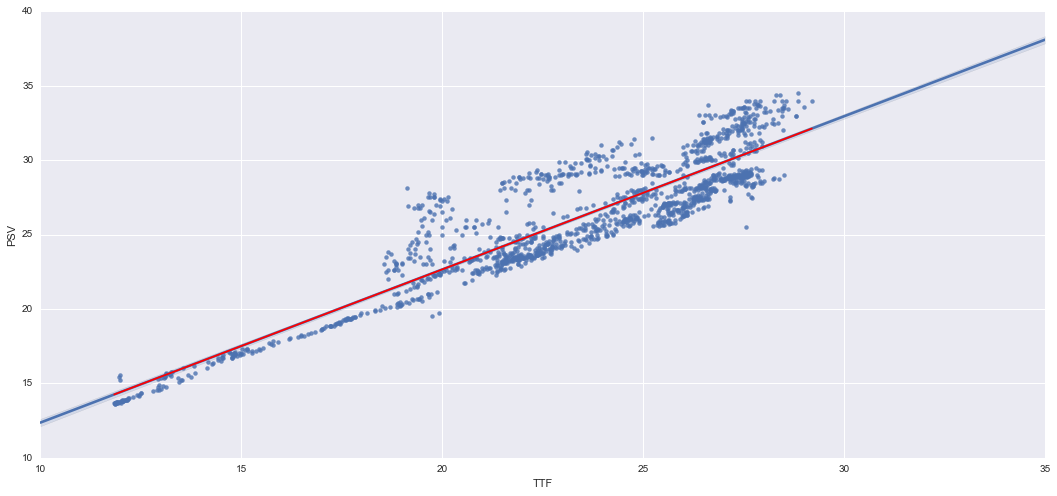

In [43]:
# generate equally spaced X values between true X range
X2 = np.linspace(X.min(), X.max(), 100)
# y estimate using OLS beta and alpha
Y_hat = X2 * beta + alpha

# Plot on top or seaborn scatter + fit
result = sns.regplot(x=df_gas.TTF, y=df_gas.PSV)
ax = result.plot(X2, Y_hat, 'r')

######## Alternative way to do it without seaborn style
# from matplotlib import pyplot as plt
# # Scatter of true data
# plt.scatter(x=X, y=Y)
# # OLS estimated line of best fit
# plt.plot(x=X2, y=Y_hat, 'r')

In [20]:
ts.coint(df_gas.TTF, df_gas.PSV)

(-3.9824495227066667,
 0.0076059934532042659,
 array([-3.43467657, -2.86345091, -2.56778734]))